In [42]:
from pathlib import Path
import os

workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/")
os.chdir(workdir)
print(f"Current working directory: {Path.cwd()}")

Current working directory: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL


In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
import sys

In [44]:
# === IMPORTS AND SETUP ===
script_dir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/Python_Code_Analysis/DL_Implement")
sys.path.insert(0, str(script_dir))

from NYS_04_dataset import WetlandDataset, find_patch_files, load_and_merge_metadata
from NYS_05_unet_model import UNet

# Configuration (must match training in NYS_06_train.ipynb)
data_dir = Path("Data/Patches_v2")
cluster_id = 208
huc_id = None

# Load metadata
files = find_patch_files(data_dir, cluster_id, huc_id)
metadata = load_and_merge_metadata(files["metadata_files"])

print(f"Loaded metadata:")
print(f"  in_channels: {metadata['in_channels']}")
print(f"  num_classes: {metadata['num_classes']}")
print(f"  band_names: {metadata['band_names']}")
print(f"  class_names: {metadata['class_names']}")

Loaded metadata:
  in_channels: 11
  num_classes: 5
  band_names: ['r', 'g', 'b', 'nir', 'ndvi', 'ndwi', 'dem', 'chm', 'slope_5m', 'TPI_5m', 'Geomorph_5m']
  class_names: ['Background', 'EMW', 'FSW', 'SSW', 'OWW']


In [45]:
# === LOAD MODEL ===
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Create model using metadata
model = UNet(
    in_channels=metadata["in_channels"],
    num_classes=metadata["num_classes"],
    base_filters=32
)

# Load trained weights
checkpoint = torch.load(workdir / "Models/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"\nLoaded model from epoch {checkpoint['epoch'] + 1}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")
print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")

Using device: mps

Loaded model from epoch 10
Validation loss: 0.9966
Validation accuracy: 0.6352


In [46]:
# === LOAD VALIDATION DATA ===
val_dataset = WetlandDataset(
    files["X_val"],
    files["y_val"],
    metadata,
    normalize=True
)
print(f"Loaded {len(val_dataset)} validation patches")

Loaded 635 validation patches


In [47]:
# === VISUALIZATION SETUP ===
class_names = metadata["class_names"]
num_classes = metadata["num_classes"]
band_names = metadata["band_names"]

# Color mapping for wetland classes
colors = ['white', 'green', 'darkgreen', 'orange', 'blue']
cmap = ListedColormap(colors)

print(f"Classes: {class_names}")
print(f"Bands: {band_names}")

Classes: ['Background', 'EMW', 'FSW', 'SSW', 'OWW']
Bands: ['r', 'g', 'b', 'nir', 'ndvi', 'ndwi', 'dem', 'chm', 'slope_5m', 'TPI_5m', 'Geomorph_5m']


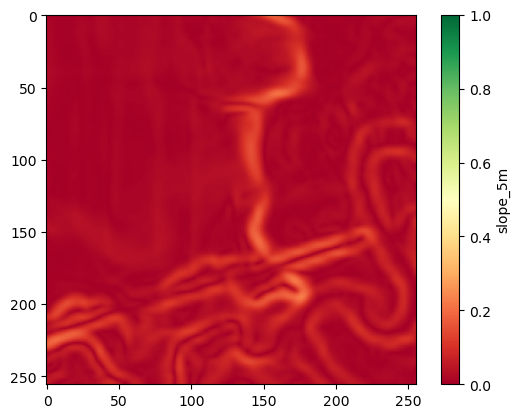

In [48]:
testX, testY = val_dataset[4]
index = band_names.index('slope_5m')
p = testX[index].numpy()
plt.imshow(p, cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(label = band_names[index])

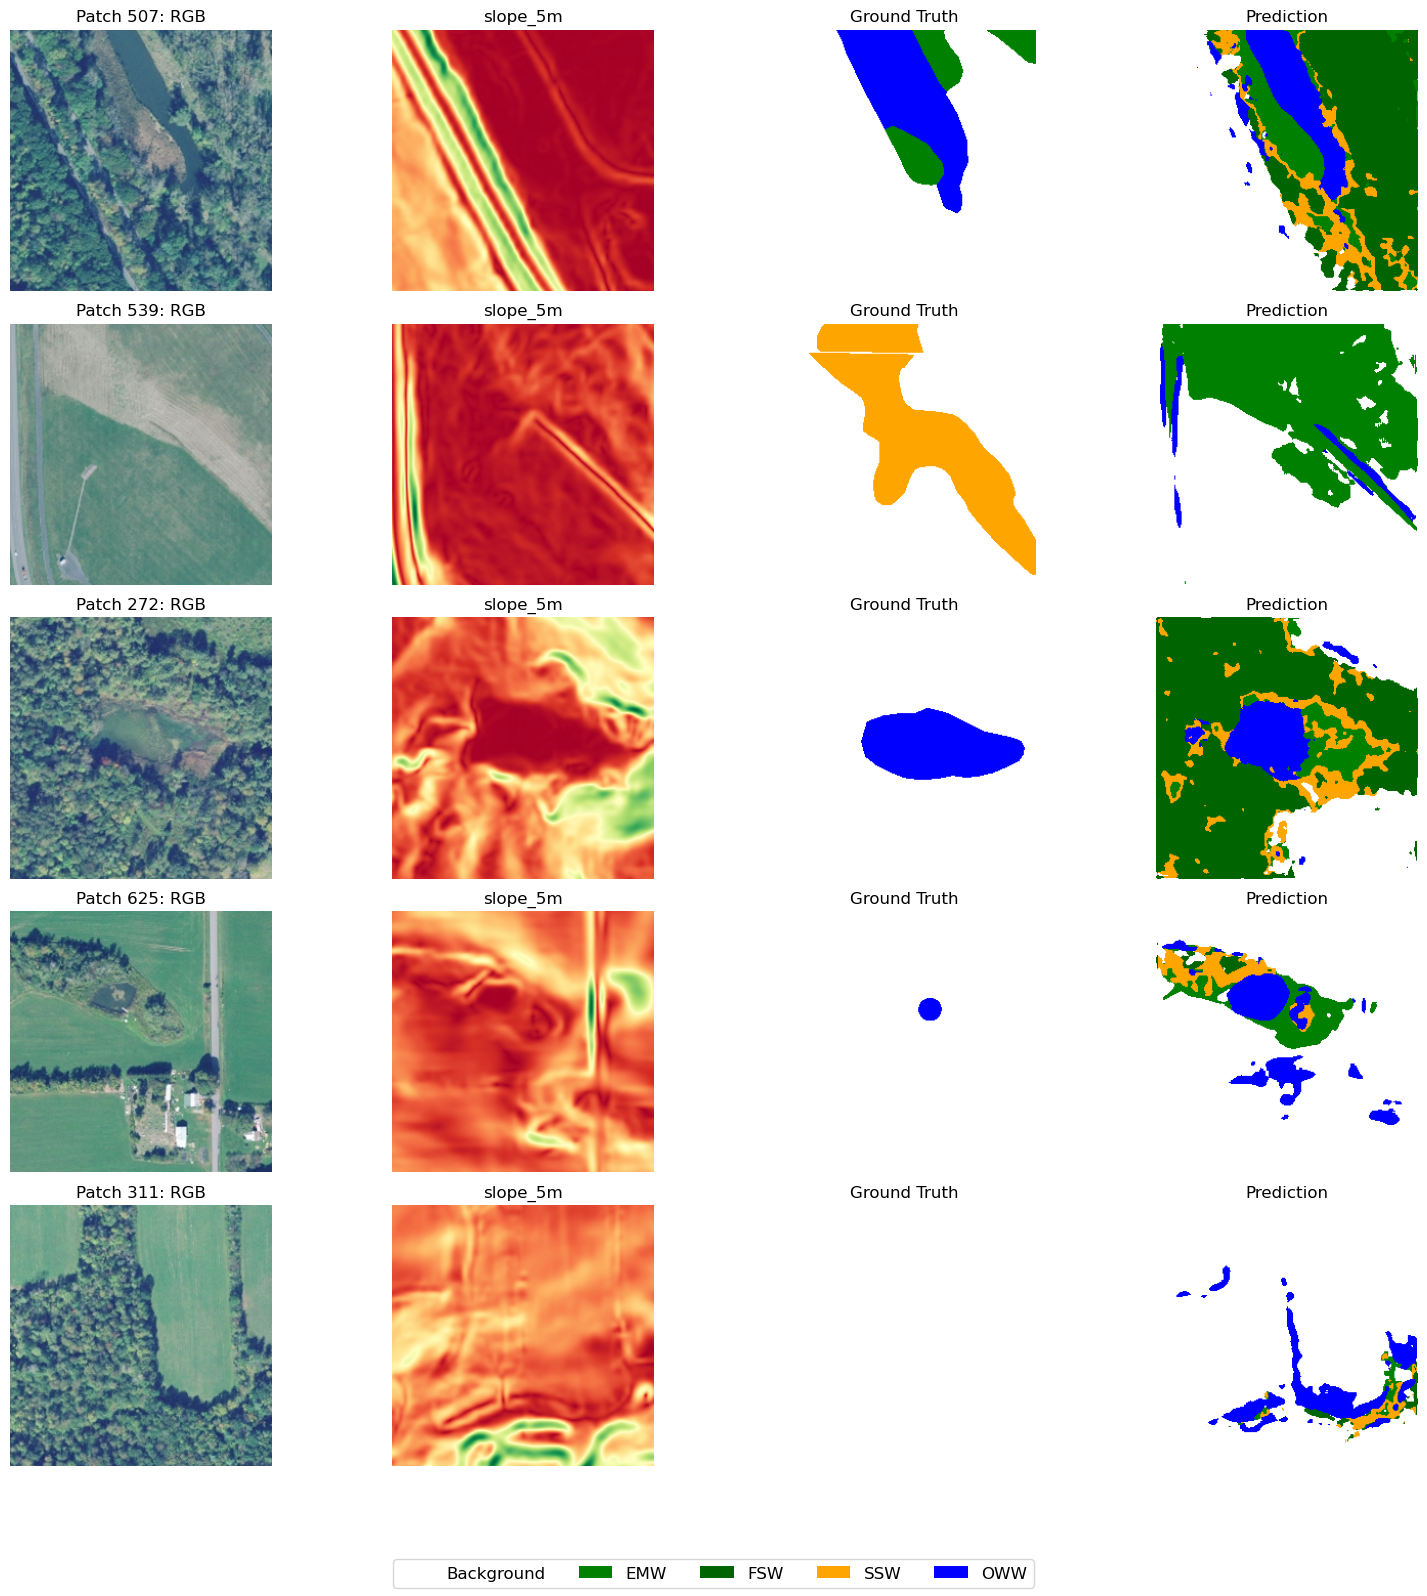


Saved visualization to Models/prediction_samples.png


In [50]:
# === PLOT SAMPLE PREDICTIONS ===
fig, axes = plt.subplots(5, 4, figsize=(16, 16))

# Select 4 random validation patches
np.random.seed(11)
indices = np.random.choice(len(val_dataset), 5, replace=False)

for row, idx in enumerate(indices):
    X, y_true = val_dataset[idx]

    # Get prediction
    with torch.no_grad():
        X_device = X.unsqueeze(0).to(device)
        output = model(X_device)
        y_pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Convert tensors to numpy for plotting
    y_true = y_true.numpy()

    # RGB image (bands 0-2, already normalized to 0-1)
    rgb = X[0:3].numpy().transpose(1, 2, 0)

    # Plot RGB
    axes[row, 0].imshow(rgb)
    axes[row, 0].set_title(f"Patch {idx}: RGB")
    axes[row, 0].axis('off')

    # Plot predictor (band index from metadata)
    pred_idx = band_names.index('slope_5m')
    pred = X[pred_idx].numpy()
    axes[row, 1].imshow(pred, cmap='RdYlGn')
    axes[row, 1].set_title(band_names[pred_idx])
    axes[row, 1].axis('off')

    # Plot ground truth
    axes[row, 2].imshow(y_true, cmap=cmap, vmin=0, vmax=num_classes-1)
    axes[row, 2].set_title("Ground Truth")
    axes[row, 2].axis('off')

    # Plot prediction
    axes[row, 3].imshow(y_pred, cmap=cmap, vmin=0, vmax=num_classes-1)
    axes[row, 3].set_title("Prediction")
    axes[row, 3].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for c, n in zip(colors, class_names)]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig(workdir / "Models/prediction_samples.png", dpi=150)
plt.show()

print(f"\nSaved visualization to Models/prediction_samples.png")